<a href="https://colab.research.google.com/github/zw2624/cancer-detection/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modeling**

## Zihe Wang, zw2624@columbia.edu

This notebook contains code for model training, testing and visualziation of the predictions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from google.colab import drive

In [ ]:
from data_utils import read_slide, find_tissue_pixels, center_tumor_check, generate_patch_random

## **Data Augmentation**

###Retrive saved images

In [2]:
drive.mount('/drive')
data_root = pathlib.Path('/drive/My Drive/adl_final')

Mounted at /drive


In [3]:
trian_path = '/drive/My Drive/adl_final/train'
val_path = '/drive/My Drive/adl_final/val'
test_path = '/drive/My Drive/adl_final/test'

train_level1 = np.load(trian_path+'/level1.npy')
train_level2 = np.load(trian_path+'/level2.npy')
train_label = np.load(trian_path+'/label.npy')

val_level1 = np.load(val_path+'/level1.npy')
val_level2 = np.load(val_path+'/level2.npy')
val_label = np.load(val_path+'/label.npy')

test_level1 = np.load(test_path+'/level1.npy')
test_level2 = np.load(test_path+'/level2.npy')
test_label = np.load(test_path+'/label.npy')

In [4]:
train_level1.shape

(2600, 299, 299, 3)

In [5]:
val_level1.shape

(500, 299, 299, 3)

In [42]:
test_level1.shape

(600, 299, 299, 3)

### Create pipeline for data augmentation



*   Brightness, saturation, contrast, hue
*   Rotate / flip: 8X augmentation



In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
def preprocess(image):
    image = tf.image.random_saturation(image, 3, 10)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    return image

In [6]:
train_gen = ImageDataGenerator(rotation_range = 90,
                width_shift_range=(-8, 8),
                height_shift_range=(-8, 8),
                brightness_range=(0.4, 0.8),
                horizontal_flip = True,
                vertical_flip = True,
                rescale=1./255,
                preprocessing_function=preprocess) 

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [7]:
def get_ds(gen, level1, level2, label, seed=2624):
    level1_gen = gen.flow(level1, label, seed=seed)
    level2_gen = gen.flow(level2, seed=seed)
    while True:
        lv1, l = level1_gen.next()
        lv2 = level2_gen.next()
        yield [lv1, lv2], l

In [8]:
train_ds = get_ds(train_gen, train_level1, train_level2, train_label)
val_ds = get_ds(val_gen, val_level1, val_level2, val_label)
test_ds = get_ds(test_gen, test_level1, test_level2, test_label)

## **Modeling**

In [9]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint

### simple model (1 level)

In [23]:
train_ds_single = train_gen.flow(train_level1, train_label)
val_ds_single = val_gen.flow(val_level1, val_label)

In [24]:
def simple_model(patch_size=299):
    input1 = Input(shape=(patch_size, patch_size, 3))
    inception_module = InceptionV3(weights='imagenet', include_top=False)
    inception_module.trainable = False
    model = Sequential()
    model.add(inception_module)
    model.add(GlobalAveragePooling2D())
    x = model(input1)
    dense = Dense(256, activation='relu')(x)
    dropout = Dropout(0.3)(dense)
    dense2 = Dense(128, activation='relu')(dropout)
    output = Dense(1, activation='sigmoid')(dense2)
    return Model(inputs=input1, outputs=output)

In [25]:
checkpoint_path = os.path.join('/drive/My Drive/adl_final', "cp-single-{epoch:08d}.ckpt")

In [26]:
simple_model = simple_model()
simple_model.compile(loss='binary_crossentropy',metrics=['accuracy'])

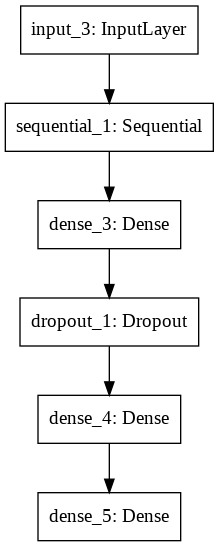

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(simple_model, to_file='simple_model.png')

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history = simple_model.fit_generator(train_ds_single,
                epochs=20,
                validation_data=val_ds_single,
                callbacks=[early_stopping, model_checkpoint_callback])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
82/82 [==============================] - 79s 878ms/step - loss: 0.6777 - accuracy: 0.7142 - val_loss: 0.3366 - val_accuracy: 0.8600
Epoch 2/20
82/82 [==============================] - 71s 868ms/step - loss: 0.3272 - accuracy: 0.8630 - val_loss: 0.3720 - val_accuracy: 0.8480
Epoch 3/20
82/82 [==============================] - 72s 875ms/step - loss: 0.2883 - accuracy: 0.8836 - val_loss: 0.3304 - val_accuracy: 0.8620
Epoch 4/20
82/82 [==============================] - 72s 878ms/step - loss: 0.2620 - accuracy: 0.8944 - val_loss: 0.3316 - val_accuracy: 0.8280
Epoch 5/20
82/82 [==============================] - 71s 864ms/step - loss: 0.2698 - accuracy: 0.8965 - val_loss: 0.3264 - val_accuracy: 0.8200
Epoch 6/20
82/82 [==============================] - 73s 891ms/step - loss: 0.2549 - accuracy: 0.9086 - val_loss: 0.3292 - val_accuracy: 0.8720
Epoch 7/20
82/82 [==============================] - 74s 904ms/step - loss: 0.2247 - accuracy: 0.9106 - val_loss: 0.2896 - val_accuracy: 0.8540

In [ ]:
x = np.linspace(0, 1, 13)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(x, loss, label='training loss')
plt.plot(x, val_acc, label='validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(x, acc, label='training accuracy')
plt.plot(x, val_acc, label='validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('single_model_eval')

### 2 levels model with inception_module

In [108]:
def two_lv_model(patch_size=299):
    input1 = Input(shape=(patch_size, patch_size, 3))
    input2 = Input(shape=(patch_size, patch_size, 3))
    inception_module_1 = InceptionV3(weights='imagenet', include_top=False)
    inception_module_2 = InceptionV3(weights='imagenet', include_top=False)
    inception_module_1.trainable = False
    inception_module_2.trainable = False
    model1 = Sequential()
    model1.add(inception_module_1)
    model1.add(GlobalAveragePooling2D())
    model2 = Sequential()
    model2.add(inception_module_2)
    model2.add(GlobalAveragePooling2D())
    x1 = model1(input1)
    x2 = model2(input2)
    x = concatenate([x1, x2])
    x = Flatten()(x)
    dense = Dense(256, activation='relu')(x)
    dropout = Dropout(0.3)(dense)
    dense2 = Dense(128, activation='relu')(dropout)
    output = Dense(1, activation='sigmoid')(dense2)
    return Model(inputs=[input1, input2], outputs=output)

In [109]:
checkpoint_path_2 = os.path.join('/drive/My Drive/adl_final/model_two_checkpoints', "cp-two-{epoch:08d}.ckpt")

In [110]:
model = two_lv_model()
model.compile(loss='binary_crossentropy',metrics=['accuracy'])

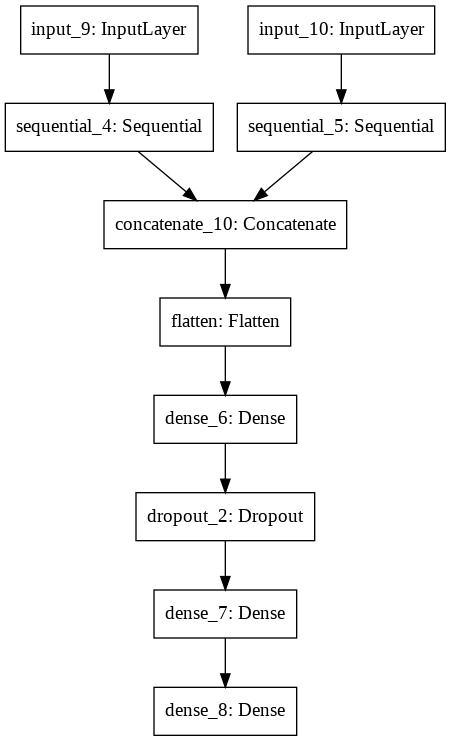

In [112]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='two_model.png')

In [113]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history = model.fit_generator(train_ds,
                epochs=30,
                validation_data=val_ds,
                steps_per_epoch=2600 // 32,
                validation_steps=500 // 32,
                callbacks=[early_stopping, model_checkpoint_callback])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
81/81 [==============================] - 141s 2s/step - loss: 1.0794 - accuracy: 0.6852 - val_loss: 0.3497 - val_accuracy: 0.8479
Epoch 2/30
81/81 [==============================] - 132s 2s/step - loss: 0.3927 - accuracy: 0.8441 - val_loss: 0.3445 - val_accuracy: 0.8521
Epoch 3/30
81/81 [==============================] - 132s 2s/step - loss: 0.2612 - accuracy: 0.8893 - val_loss: 0.7713 - val_accuracy: 0.6979
Epoch 4/30
81/81 [==============================] - 133s 2s/step - loss: 0.2642 - accuracy: 0.8828 - val_loss: 0.3562 - val_accuracy: 0.8021
Epoch 5/30
81/81 [==============================] - 134s 2s/step - loss: 0.2389 - accuracy: 0.9033 - val_loss: 0.3624 - val_accuracy: 0.8062
Epoch 6/30
81/81 [==============================] - 134s 2s/step - loss: 0.2573 - accuracy: 0.8919 - val_loss: 0.2667 - val_accuracy: 0.8625
Epoch 7/30
81/81 [==============================] - 134s 2s/step - loss: 0.2246 - accuracy: 0.9080 - val_loss: 0.2549 - val_accuracy: 0.8625
Epoch 8/30
81

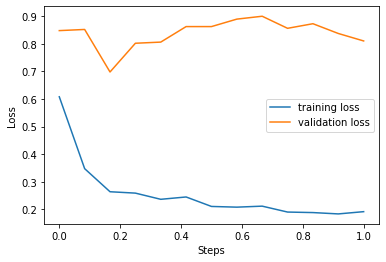

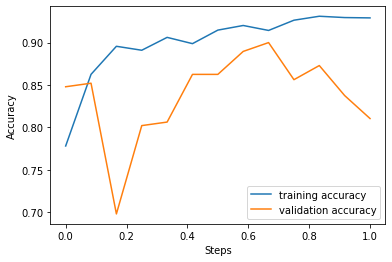

<Figure size 432x288 with 0 Axes>

In [114]:
x = np.linspace(0, 1, 13)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(x, loss, label='training loss')
plt.plot(x, val_acc, label='validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(x, acc, label='training accuracy')
plt.plot(x, val_acc, label='validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('two_model_eval')

load weight

In [45]:
model = two_lv_model()
latest = tf.train.latest_checkpoint('/drive/My Drive/adl_final/model_two_checkpoints')
model.load_weights(latest)

In [47]:
model.compile(loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

### run test on best model (this one)

In [49]:
model.evaluate_generator(test_ds, steps=600//32)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.30525732040405273,
 0.8204225301742554,
 0.8608695864677429,
 0.7388059496879578,
 0.9395708441734314]

### 2 levels model with VGG16 module

In [10]:
def two_lv_model_vgg(patch_size=299):
    input1 = Input(shape=(patch_size, patch_size, 3))
    input2 = Input(shape=(patch_size, patch_size, 3))
    inception_module_1 = VGG16(weights='imagenet', include_top=False)
    inception_module_2 = VGG16(weights='imagenet', include_top=False)
    inception_module_1.trainable = False
    inception_module_2.trainable = False
    model1 = Sequential()
    model1.add(inception_module_1)
    model1.add(GlobalAveragePooling2D())
    model2 = Sequential()
    model2.add(inception_module_2)
    model2.add(GlobalAveragePooling2D())
    x1 = model1(input1)
    x2 = model2(input2)
    x = concatenate([x1, x2])
    x = Flatten()(x)
    dense = Dense(256, activation='relu')(x)
    dropout = Dropout(0.3)(dense)
    dense2 = Dense(128, activation='relu')(dropout)
    output = Dense(1, activation='sigmoid')(dense2)
    return Model(inputs=[input1, input2], outputs=output)

In [11]:
checkpoint_path_3 = os.path.join('/drive/My Drive/adl_final/model_two_vgg_checkpoints', "cp-two-{epoch:08d}.ckpt")
model_vgg = two_lv_model_vgg()
model_vgg.compile(loss='binary_crossentropy',metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_3,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
81/81 [==============================] - 135s 2s/step - loss: 0.6740 - accuracy: 0.6243 - val_loss: 0.5879 - val_accuracy: 0.6208
Epoch 2/30
81/81 [==============================] - 129s 2s/step - loss: 0.5336 - accuracy: 0.7529 - val_loss: 1.5753 - val_accuracy: 0.4833
Epoch 3/30
81/81 [==============================] - 130s 2s/step - loss: 0.4698 - accuracy: 0.7844 - val_loss: 1.8307 - val_accuracy: 0.5063
Epoch 4/30
81/81 [==============================] - 131s 2s/step - loss: 0.4729 - accuracy: 0.7723 - val_loss: 2.6290 - val_accuracy: 0.5042
Epoch 5/30
81/81 [==============================] - 131s 2s/step - loss: 0.4458 - accuracy: 0.7908 - val_loss: 1.7065 - val_accuracy: 0.4938


memory crashed when first run

In [12]:
history = model_vgg.fit_generator(train_ds,
                epochs=30,
                validation_data=val_ds,
                steps_per_epoch=2600 // 32,
                validation_steps=500 // 32,
                callbacks=[early_stopping, model_checkpoint_callback])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
81/81 [==============================] - 130s 2s/step - loss: 0.4558 - accuracy: 0.7921 - val_loss: 2.3817 - val_accuracy: 0.5104
Epoch 2/30
81/81 [==============================] - 128s 2s/step - loss: 0.4390 - accuracy: 0.8006 - val_loss: 1.0096 - val_accuracy: 0.5771
Epoch 3/30
81/81 [==============================] - 127s 2s/step - loss: 0.4413 - accuracy: 0.7952 - val_loss: 1.7634 - val_accuracy: 0.5500
Epoch 4/30
81/81 [==============================] - 126s 2s/step - loss: 0.4190 - accuracy: 0.8092 - val_loss: 3.9278 - val_accuracy: 0.5083
Epoch 5/30
81/81 [==============================] - 128s 2s/step - loss: 0.4277 - accuracy: 0.8022 - val_loss: 1.6677 - val_accuracy: 0.5833
Epoch 6/30
81/81 [==============================] - 128s 2s/step - loss: 0.4198 - accuracy: 0.8061 - val_loss: 1.8512 - val_accuracy: 0.5500


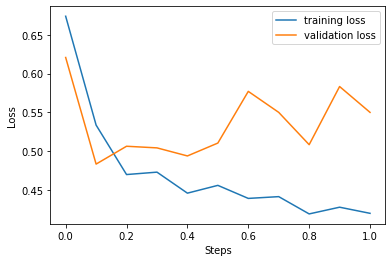

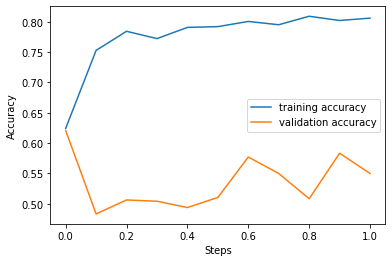

<Figure size 432x288 with 0 Axes>

In [14]:
x = np.linspace(0, 1, 11)
acc = [0.6243, 0.7529, 0.7844, 0.7723, 0.7908]+ history.history['accuracy']
val_acc = [0.6208, 0.4833, 0.5063, 0.5042, 0.4938] + history.history['val_accuracy']
loss = [0.6740, 0.5336, 0.4698, 0.4729, 0.4458] + history.history['loss']
val_loss = [0.5879, 1.5753, 1.8307, 2.6290, 1.7065] + history.history['val_loss']
plt.figure()
plt.plot(x, loss, label='training loss')
plt.plot(x, val_acc, label='validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(x, acc, label='training accuracy')
plt.plot(x, val_acc, label='validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('two_model_eval')

## **Heatmap**

Due to the limitation of the colab, when I try to predict on each level-1 or level-2 patch, the memory always crash. So, I create the heatmap using the following way:



*   loop on every level-5 patch, select the middle of 4 level-4 patches and predict on level-1 and level-2. label the whole patch to be tumor if there is >= 1 predicted tumor. (since it is bad to give false negative)
*   when the patch is not tissue, ignore.
*   use cv2 to resize the image --> create a heatmap like plot

Note, many functions are still very time and memory consuming. its better to save the intermediate results.



In [ ]:
model = two_lv_model()
latest = tf.train.latest_checkpoint('/drive/My Drive/adl_final/model_two_checkpoints')
model.load_weights(latest)
model.compile(loss='binary_crossentropy',metrics=['accuracy'])

or

In [134]:
model = tf.keras.models.load_model("my_model.h5")

In [137]:
drive.mount('/drive')
test_image_paths = ['/drive/My Drive/adl_final/tumor_016.tif', '/drive/My Drive/adl_final/tumor_012.tif', '/drive/My Drive/adl_final/tumor_031.tif']
test_mask_paths = ['/drive/My Drive/adl_final/tumor_016_mask.tif', '/drive/My Drive/adl_final/tumor_012_mask.tif', '/drive/My Drive/adl_final/tumor_031_mask.tif']

Mounted at /drive


Slide 016

In [138]:
import itertools
test_slide = open_slide(test_image_paths[0])
test_mask = open_slide(test_mask_paths[0])
image_slide = read_slide(test_slide, 0, 0, base_level, width=test_slide.level_dimensions[base_level][0], height=test_slide.level_dimensions[base_level][1])
mask_slide = read_slide(test_mask, 0, 0, base_level, width=test_mask.level_dimensions[base_level][0], height=test_mask.level_dimensions[base_level][1])[:,:,0]
(W, H) = test_slide.level_dimensions[5]
num_patch_width = W // patch_size
num_patch_height = H // patch_size
prediction = np.zeros((num_patch_width, num_patch_height)).astype(float)
for i in range(num_patch_width):
    for j in range(num_patch_height):
        xs = [i * patch_size * 32 + patch_size * 16, (i+1) * patch_size * 32 - patch_size * 16]
        ys = [j * patch_size * 32 + patch_size * 16, (j+1) * patch_size * 32 - patch_size * 16]
        preds = 0 
        for x, y in list(itertools.product(xs, ys)):
            patch_image_l1, patch_mask_l1 = generate_patch_random(image_slide, mask_slide, base_level=5, level=1, x=int(x), y=int(y))
            patch_image_l2, patch_mask_l2 = generate_patch_random(image_slide, mask_slide, base_level=5, level=1, x=int(x), y=int(y))
            patch_image_l1 = patch_image_l1.reshape(1, 299, 299, 3)
            patch_image_l2 = patch_image_l2.reshape(1, 299, 299, 3)
            patch_image_l1 = patch_image_l1 / 255
            patch_image_l2 = patch_image_l2 / 255
            pred = model.predict([patch_image_l1, patch_image_l2])[0][0]
            preds += pred
        if preds >= 1:
            prediction[i, j] = 1

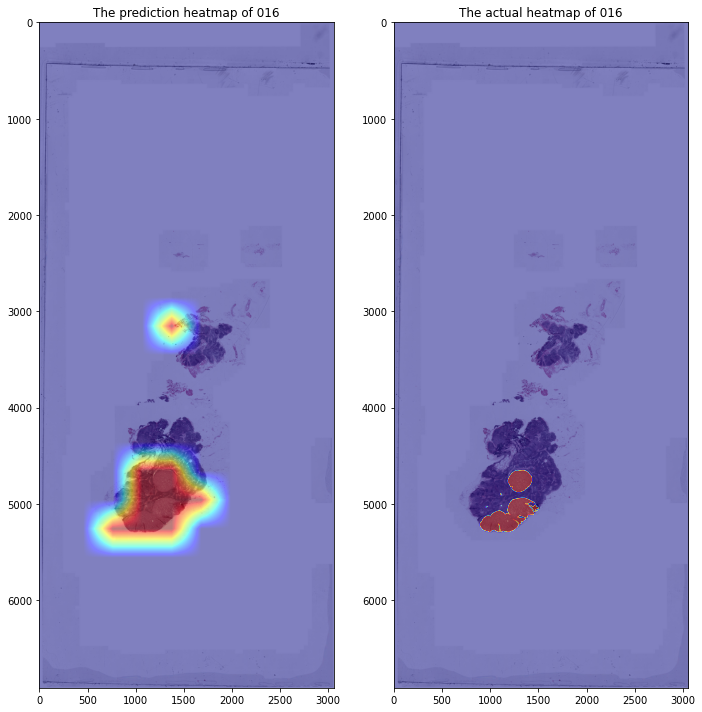

In [142]:
import cv2
reshape_mask = cv2.resize(prediction.T, (image_slide.shape[1],image_slide.shape[0]))
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(image_slide)
ax1.imshow(reshape_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.
ax1.set_title(f'The prediction heatmap of 016')

ax2.imshow(image_slide)
ax2.imshow(mask_slide, cmap='jet', alpha=0.5) # Red regions contains cancer.
ax2.set_title(f'The actual heatmap of 016')

plt.tight_layout()

Slide 12

In [142]:
test_slide = open_slide(test_image_paths[1])
test_mask = open_slide(test_mask_paths[1])
image_slide = read_slide(test_slide, 0, 0, base_level, width=test_slide.level_dimensions[base_level][0], height=test_slide.level_dimensions[base_level][1])
mask_slide = read_slide(test_mask, 0, 0, base_level, width=test_mask.level_dimensions[base_level][0], height=test_mask.level_dimensions[base_level][1])[:,:,0]
(W, H) = test_slide.level_dimensions[5]
num_patch_width = W // patch_size
num_patch_height = H // patch_size
prediction = np.zeros((num_patch_width, num_patch_height)).astype(float)
for i in range(num_patch_width):
    for j in range(num_patch_height):
        xs = [i * patch_size * 32 + patch_size * 16, (i+1) * patch_size * 32 - patch_size * 16]
        ys = [j * patch_size * 32 + patch_size * 16, (j+1) * patch_size * 32 - patch_size * 16]
        preds = 0 
        for x, y in list(itertools.product(xs, ys)):
            patch_image_l1, patch_mask_l1 = generate_patch_random(image_slide, mask_slide, base_level=5, level=1, x=int(x), y=int(y))
            patch_image_l2, patch_mask_l2 = generate_patch_random(image_slide, mask_slide, base_level=5, level=1, x=int(x), y=int(y))
            patch_image_l1 = patch_image_l1.reshape(1, 299, 299, 3)
            patch_image_l2 = patch_image_l2.reshape(1, 299, 299, 3)
            patch_image_l1 = patch_image_l1 / 255
            patch_image_l2 = patch_image_l2 / 255
            pred = model.predict([patch_image_l1, patch_image_l2])[0][0]
            preds += pred
        if preds >= 1:
            prediction[i, j] = 1

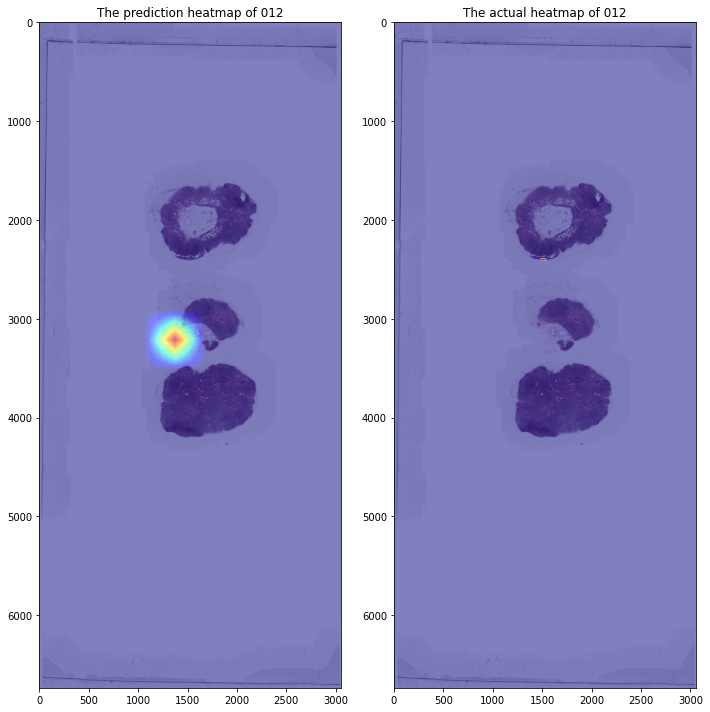

In [143]:
import cv2
reshape_mask = cv2.resize(prediction.T, (image_slide.shape[1],image_slide.shape[0]))
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(image_slide)
ax1.imshow(reshape_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.
ax1.set_title(f'The prediction heatmap of 012')

ax2.imshow(image_slide)
ax2.imshow(mask_slide, cmap='jet', alpha=0.5) # Red regions contains cancer.
ax2.set_title(f'The actual heatmap of 012')

plt.tight_layout()

Slide 31

In [143]:
test_slide = open_slide(test_image_paths[2])
test_mask = open_slide(test_mask_paths[2]

In [143]:
image_slide = read_slide(test_slide, 0, 0, base_level, width=test_slide.level_dimensions[base_level][0], height=test_slide.level_dimensions[base_level][1])
mask_slide = read_slide(test_mask, 0, 0, base_level, width=test_mask.level_dimensions[base_level][0], height=test_mask.level_dimensions[base_level][1])[:,:,0]
(W, H) = test_slide.level_dimensions[5]
num_patch_width = W // patch_size
num_patch_height = H // patch_size
prediction = np.zeros((num_patch_width, num_patch_height)).astype(float)
for i in range(num_patch_width):
    for j in range(num_patch_height):
        xs = [i * patch_size * 32 + patch_size * 16, (i+1) * patch_size * 32 - patch_size * 16]
        ys = [j * patch_size * 32 + patch_size * 16, (j+1) * patch_size * 32 - patch_size * 16]
        preds = 0 
        for x, y in list(itertools.product(xs, ys)):
            patch_image_l1, patch_mask_l1 = generate_patch_random(image_slide, mask_slide, base_level=5, level=1, x=int(x), y=int(y))
            patch_image_l2, patch_mask_l2 = generate_patch_random(image_slide, mask_slide, base_level=5, level=1, x=int(x), y=int(y))
            patch_image_l1 = patch_image_l1.reshape(1, 299, 299, 3)
            patch_image_l2 = patch_image_l2.reshape(1, 299, 299, 3)
            patch_image_l1 = patch_image_l1 / 255
            patch_image_l2 = patch_image_l2 / 255
            pred = model.predict([patch_image_l1, patch_image_l2])[0][0]
            preds += pred
        if preds >= 1:
            prediction[i, j] = 1

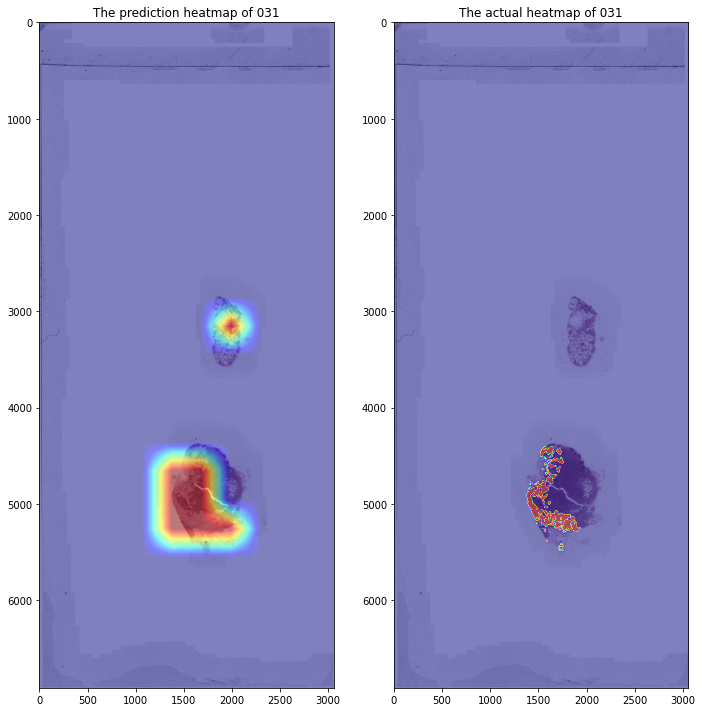

In [144]:
import cv2
reshape_mask = cv2.resize(prediction.T, (image_slide.shape[1],image_slide.shape[0]))
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(image_slide)
ax1.imshow(reshape_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.
ax1.set_title(f'The prediction heatmap of 031')

ax2.imshow(image_slide)
ax2.imshow(mask_slide, cmap='jet', alpha=0.5) # Red regions contains cancer.
ax2.set_title(f'The actual heatmap of 031')

plt.tight_layout()